In [28]:
#Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
# from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img


In [29]:
# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU not available :(


[]

In [30]:
#reading labels csv file
#C:\Python1\Model_HTTM\training.csv
labels = pd.read_csv('C:/Python1/Model_HTTM/training.csv')
labels.head()

,name,action,age
0,Image_265,normal,1
1,Image_266,normal,1
2,Image_267,fight,18
3,Image_268,normal,1
4,Image_269,romatic,18


In [31]:
#describe
# labels.describe()
print(labels.columns)

Index(['name ', 'action ', 'age '], dtype='object')


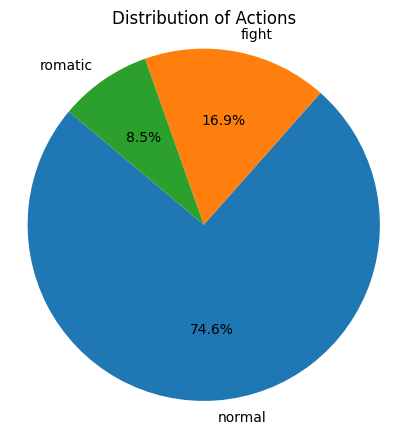

In [32]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in the 'action' column
action_counts = labels['action '].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(action_counts, labels=action_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Actions')
plt.show()

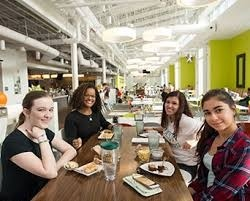

In [33]:
# Lets check one image
from IPython.display import display, Image
Image("C:/Python1/Model_HTTM/train/Image_265.jpg")

In [34]:
import os
if len(os.listdir('C:/Python1/Model_HTTM/train/')) == len(labels['name ']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [35]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['action '])))
n_classes = len(classes)
print('Total unique action  {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique action  3


{'fight': 0, 'normal': 1, 'romatic': 2}

In [36]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['action ']
#     image_labels = label_dataframe[0]
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['name '].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
#dog_breed ---> action:       
        action = image_labels[ix]
        y[ix] = class_to_num[action]
    
    y = to_categorical(y)
    
    return images,y

In [37]:
from tqdm import tqdm
import time 
t = time.time()

X,y = images_to_array('C:/Python1/Model_HTTM/train/', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

100%|██████████| 59/59 [00:00<00:00, 599.99it/s]

runtime in seconds: 0.10387110710144043


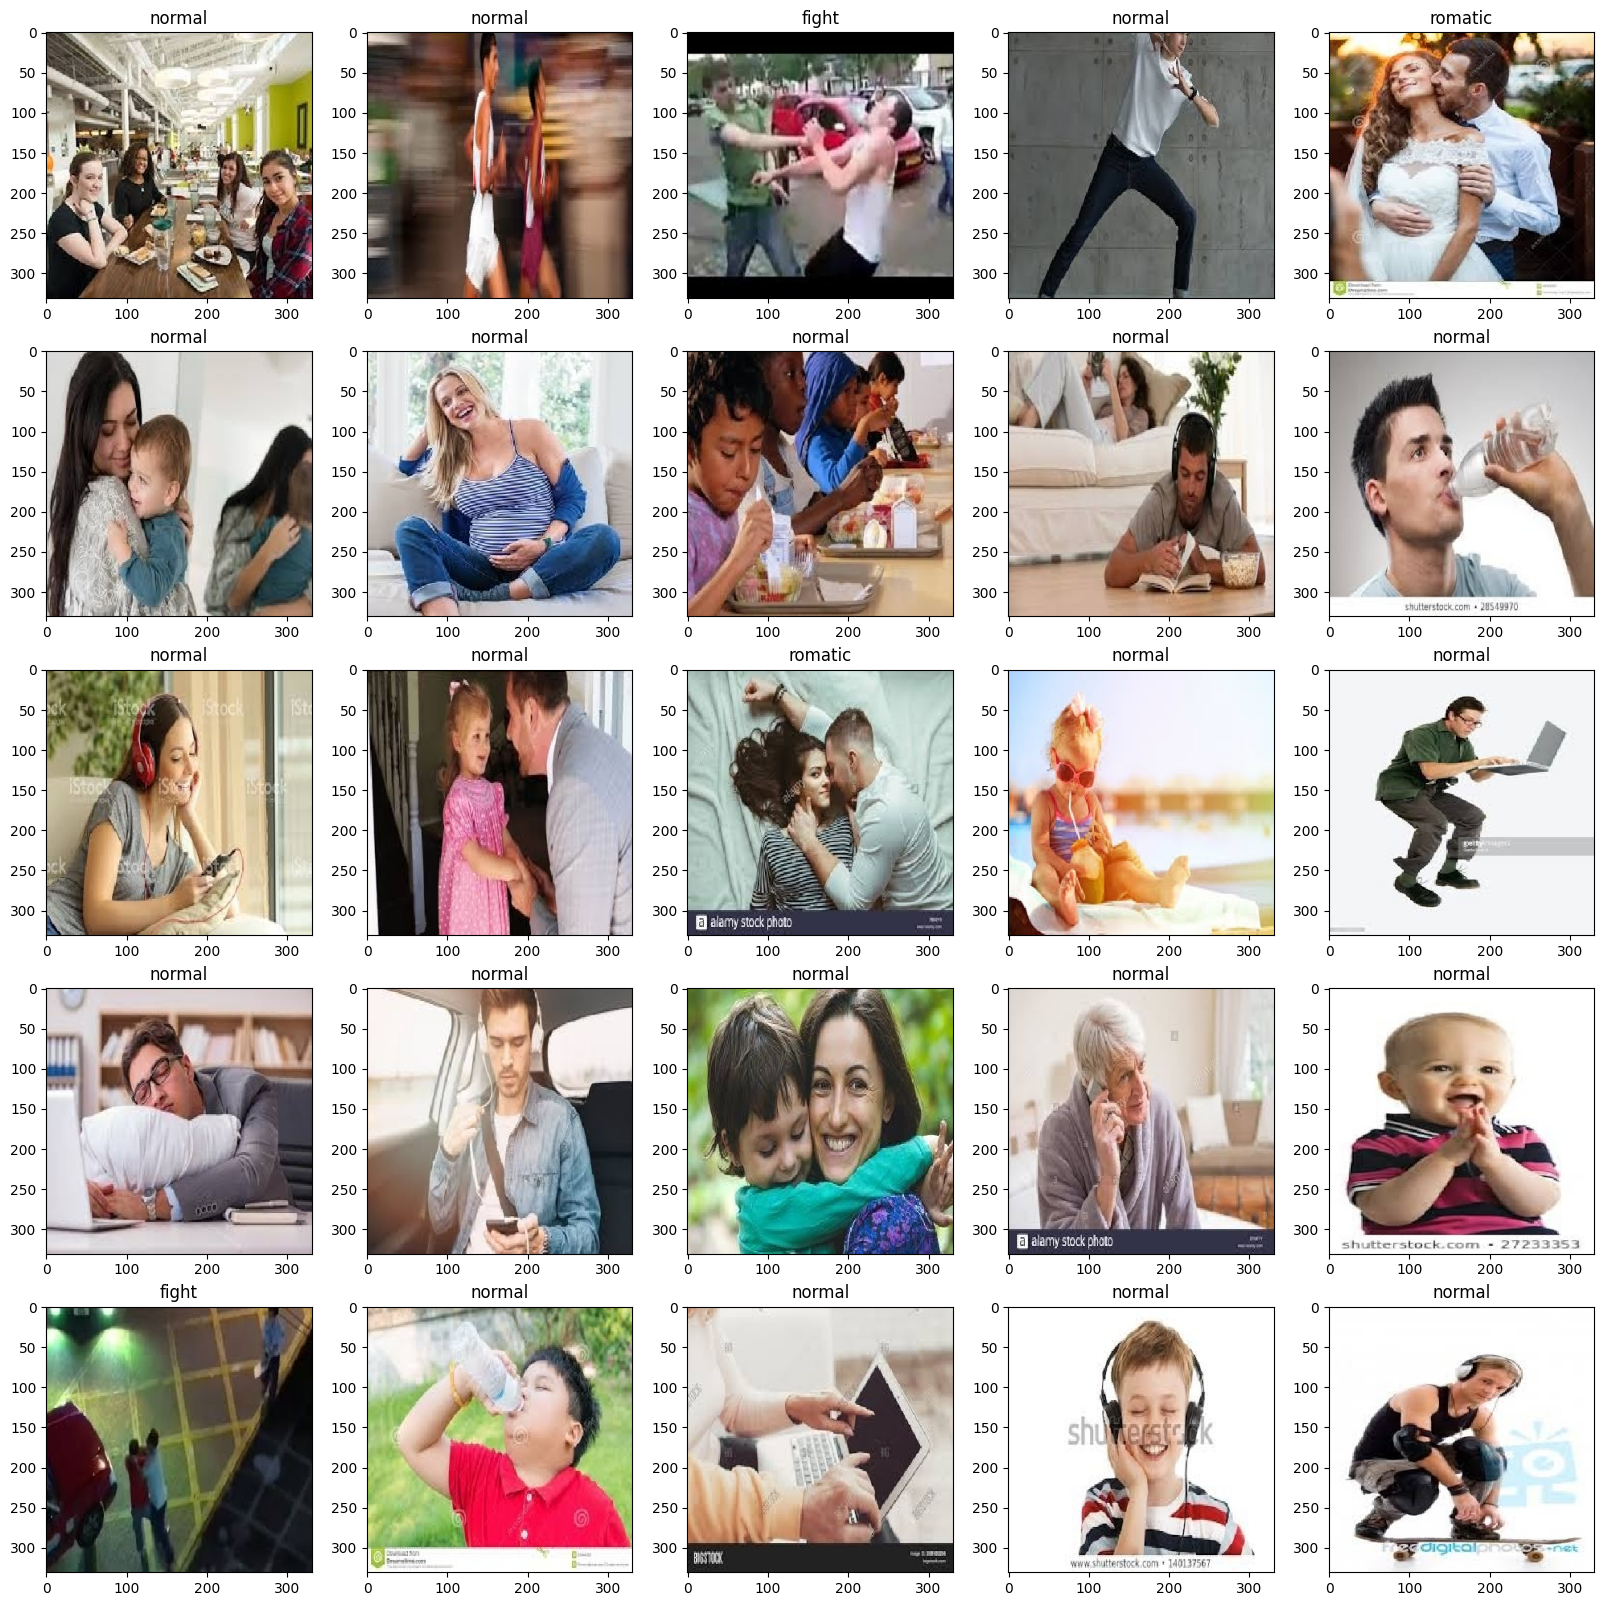

In [38]:
# np.where(y[5]==1)[0][0]

# lets check some dogs and their breeds
n=25

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image

In [39]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [40]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [41]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [42]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

2/2 [==============================] - 6s 2s/step
Feature maps shape:  (59, 2048)


In [43]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

2/2 [==============================] - 8s 3s/step
Feature maps shape:  (59, 2048)


In [44]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

2/2 [==============================] - 16s 5s/step
Feature maps shape:  (59, 1536)


In [45]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

2/2 [==============================] - 34s 12s/step
Feature maps shape:  (59, 4032)


In [46]:
del X #to free up some ram memory
gc.collect()

226202

In [47]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

Final feature maps shape (59, 9664)


In [50]:
#Prepare Deep net
model = Sequential()
model.add(Dense(1028, input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model.
# history = model.fit(final_features, y,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_split=0.2,
#                     callbacks=[lrr, EarlyStop])

In [51]:

import cv2
import os

# Đường dẫn đến video
video_path = 'C:/Python1/Model_HTTM/test/test01.mp4'

# Thư mục để lưu các ảnh cắt ra từ video
output_directory = 'C:/Python1/Model_HTTM/test/frames/'

# Tạo thư mục nếu nó chưa tồn tại
os.makedirs(output_directory, exist_ok=True)

# Mở video để đọc
cap = cv2.VideoCapture(video_path)

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break

    # Lưu frame thành một tệp ảnh
    frame_filename = os.path.join(output_directory, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)

    frame_count += 20

cap.release()
cv2.destroyAllWindows()


In [52]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

1105

In [53]:
#Function to read images from test directory

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('C:/Python1/Model_HTTM/test/frames/', img_size)

  0%|          | 0/220 [00:00<?, ?it/s]

100%|██████████| 220/220 [00:01<00:00, 190.43it/s]

Ouptut Data Size:  (220, 331, 331, 3)


In [54]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

test_features = extact_features(test_data)

7/7 [==============================] - 18s 2s/step
Feature maps shape:  (220, 2048)
7/7 [==============================] - 31s 4s/step
Feature maps shape:  (220, 2048)
7/7 [==============================] - 96s 13s/step
Feature maps shape:  (220, 4032)
7/7 [==============================] - 44s 6s/step
Feature maps shape:  (220, 1536)
Final feature maps shape (220, 9664)


In [55]:
#Free up some space.
del test_data
gc.collect()

0

In [56]:
#Predict test labels given test data features.

pred = model.predict(test_features)

7/7 [==============================] - 0s 9ms/step


In [57]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[0.52016723 0.21469437 0.26513845]
Max value (probability of prediction): 0.5201672315597534
Sum: 1.0
Max index: 0
Predicted label: fight


In [62]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["name"] + list(classes))
preds_df.head()

,name,fight,normal,romatic


In [63]:
# Append test image ID's to predictions DataFrame
test_path = "C:/Python1/Model_HTTM/test/frames/"
preds_df["name"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,name,fight,normal,romatic
0,frame_0000,NaN,NaN,NaN
1,frame_0020,NaN,NaN,NaN
2,frame_0040,NaN,NaN,NaN
3,frame_0060,NaN,NaN,NaN
4,frame_0080,NaN,NaN,NaN


In [68]:
preds_df.loc[:,list(classes)]= pred
preds_df.to_csv('submission.csv',index=None)
preds_df.head()


,name,fight,normal,romatic
0,frame_0000,0.520167,0.214694,0.265138
1,frame_0020,0.534017,0.204685,0.261298
2,frame_0040,0.532845,0.21118,0.255974
3,frame_0060,0.545962,0.216011,0.238027
4,frame_0080,0.557645,0.202694,0.23966


In [69]:
import json

# Tạo một danh sách để lưu trữ dữ liệu
output_data = []

# Điều kiện: Xác suất lớn hơn 0.51
threshold = 0.51

# Lặp qua các hàng của DataFrame preds_df
for index, row in preds_df.iterrows():
    name = row['name']
    fight_prob = row['fight']
    romantic_prob = row['romatic']
    normal_prob = row['normal']
    
    # Kiểm tra điều kiện
    if fight_prob > threshold:
        label = "fight"
        value = 18
    elif romantic_prob > threshold:
        label = "romatic"
        value = 18
    elif normal_prob > threshold:
        label = "normal"
        value = 1
    else:
        continue  # Không thỏa mãn điều kiện, bỏ qua
    
    # Tạo một từ điển cho mỗi hàng thỏa mãn điều kiện
    entry = {
        "name": name,
        "label": label,
        "value": value
    }
    
    # Thêm từ điển vào danh sách
    output_data.append(entry)

# Lưu danh sách vào một tệp JSON
with open("output.json", "w") as json_file:
    json.dump(output_data, json_file, indent=4)


KeyError: 'romantic'